# Basis Vectors used by FFTW rfft() Function

Bernard J. Rauscher<br>
NASA Goddard Space Flight Center

14 April 2021

## 1. Introduction

The purpose of this notebook is to confirm that I correctly understand the basis vectors used by Julia's FFT library: FFTW. According to the online documentation (http://www.fftw.org/doc/The-1d-Real_002ddata-DFT.html#The-1d-Real_002ddata-DFT), this is what is computed for inverse FFTs,

<center>$Y_k=\sum_{j=0}^{n-1}X_j e^{2\pi j k \sqrt{-1}/n}.\hspace{18pt}k\in\{0,1,\dots n/2\}\hspace{18pt}(1)$</center>

Julia uses unity-offset arrays, so Eq. 1 must be altered to read,

<center>$Y_k=\sum_{j=1}^{n}X_j e^{2\pi (j-1) (k-1) \sqrt{-1}/n}.\hspace{18pt}k\in\{1,2,\dots\frac{n}{2}+1\}\hspace{18pt}(2)$</center>

By inspection, the basis vectors are,

<center>$\mathbf{B}_k^j=e^{2\pi (j-1) (k-1) \sqrt{-1}/n}.\hspace{18pt}(3)$</center>

Make some and see how it works. I'm guessing that the normalization is not correct.

## 2. Testing Eq. 3

In [33]:
# Standard imports
using Revise
using FFTW
using Plots
using Random
using LinearAlgebra
using LaTeXStrings

In [34]:
# Make a vector of random numbers
n = 128
Random.seed!(1234)
d = rand(n);

In [35]:
# Compute the real FFT
𝓭 = rfft(d);

In [36]:
# Build the basis matrix given by Eq. 3
B = zeros(Complex,(n,n÷2+1))
for k in 1:n÷2+1
    for j in 1:n
        B[j,k] = exp(2π*1im * (j-1) * (k-1) /n)
    end
end

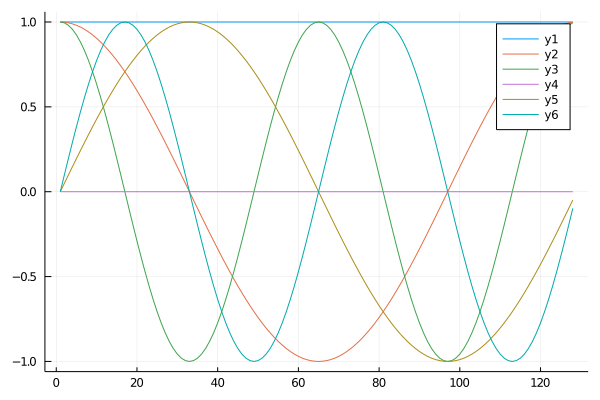

In [37]:
# Plot a few. I expect to see sines and cosines -and I do
plot([real(B[:,1:3]),imag(B[:,1:3])])

We require an operator to compute the incomplete Fourier transform given a vector of data. It is tentatively,

<center>$\mathbf{F}=\mathbf{B}^+.\hspace{18pt}(4)$</center>

The next few cells show that the normalization is wrong (as expected).

In [38]:
# Create the incomplete Fourier transform operator
F = pinv(B);

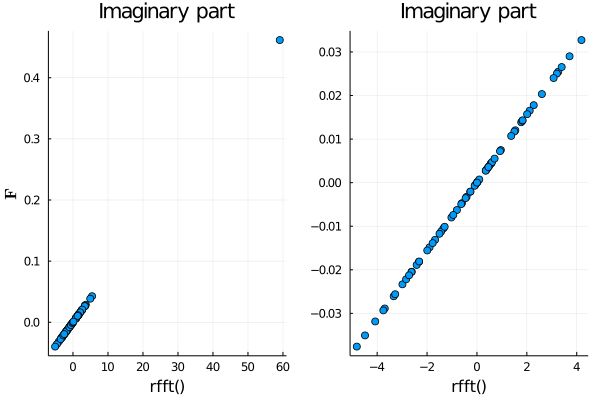

In [39]:
# Make some plots and show that it does not work
plt1 = scatter(real(𝓭), real(F*d), xlabel="rfft()", ylabel=L"\mathbf{F}",
            title="Real part")
plt2 = scatter(imag(𝓭), imag(F*d))
plot(plt1, plt2, layout=(1,2), legend=false, xlabel="rfft()",
            title="Imaginary part")

## 3. Fixing It

Assume that we have the normalization wrong. In fact, the basis vectors seem to be,

<center>$\mathbf{B}_k^j=\frac{1}{n}e^{2\pi (j-1) (k-1) \sqrt{-1}/n}.\hspace{18pt}(5)$</center>

Plot it up.

In [40]:
F = pinv(B/n);

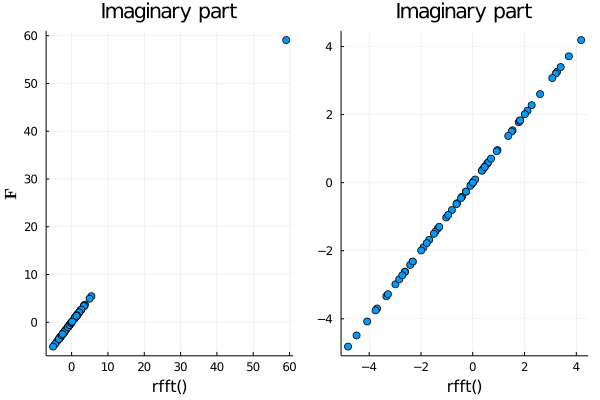

In [41]:
plt1 = scatter(real(𝓭), real(F*d), xlabel="rfft()", ylabel=L"\mathbf{F}",
            title="Real part")
plt2 = scatter(imag(𝓭), imag(F*d))
plot(plt1, plt2, layout=(1,2), legend=false, xlabel="rfft()",
            title="Imaginary part")

## 4. Question about FFTW

The C language FFTW documenation says, "Like FFTW’s complex DFT, these transforms are unnormalized. In other words, applying the real-to-complex (forward) and then the complex-to-real (backward) transform will multiply the input by n." Is this true in Julia?

Treating $\mathbf{d}$ as a vector, compute the difference between $\mathbf{d}$ and $\textrm{irfft}(\mathbf{\textrm{rfft}(d)})$.

In [26]:
δ = norm(d .- irfft(rfft(d), n))

1.0772954026114418e-15

So, no, this caveat is not true in Julia. The Julia documentation is unfortunately insufficiently clear on this point.

## 5. Conclusion

We have shown that Eq. 5 gives the correct form for the Fourier basis vectors used by Julia, and Eq. 4 given an operator that can be used to compute Fourier transforms (either complete or incomplete). Obviously, if computing the full Fourier transform, the FFT algoritm is fast than projection using $\mathbf{F}$. The advantage of $\mathbf{F}$ is that it can be used to handle time series containing gaps without interpolating.